In [251]:
import cv2
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook
# import hdbscan

import matplotlib.pyplot as plt
%matplotlib inline


In [41]:
img_path = "/home/user/projects/agrivision/data/Agriculture-Vision/train/images/rgb/1DJX4RH9N_6886-1513-7398-2025.jpg"

In [9]:
img_path = "/home/user/projects/agrivision/data/Agriculture-Vision/val/labels/cloud_shadow/TCK29494G_3036-3809-3548-4321.png"

In [181]:
gray = cv2.imread(img_path)

In [182]:
scale = 1
delta = 0
ddepth = cv2.CV_16S

grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
# Gradient-Y
# grad_y = cv.Scharr(gray,ddepth,0,1)
grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)


abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)


grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)


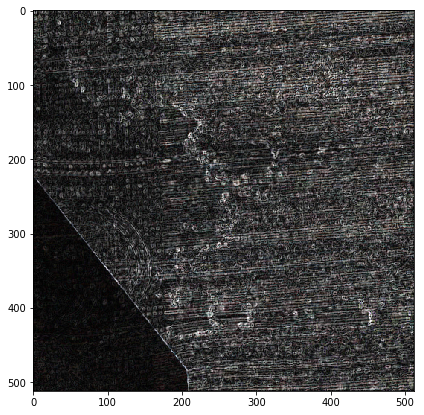

In [186]:
plt.figure(figsize=(7,7))
plt.imshow(grad)

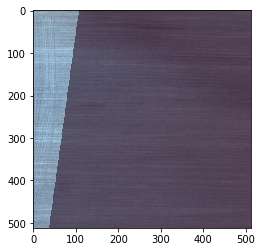

In [84]:
plt.imshow(gray)

In [44]:
lab= cv2.cvtColor(gray, cv2.COLOR_RGB2LAB)

(array([2.0809e+04, 2.9357e+04, 5.6060e+04, 6.1896e+04, 5.5129e+04,
        2.9681e+04, 7.9570e+03, 1.0990e+03, 1.3400e+02, 2.2000e+01]),
 array([ 29. ,  51.1,  73.2,  95.3, 117.4, 139.5, 161.6, 183.7, 205.8,
        227.9, 250. ]),
 <a list of 10 Patch objects>)

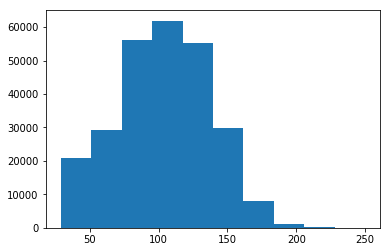

In [187]:
plt.hist(lab[:, :,0].flatten())

109.0


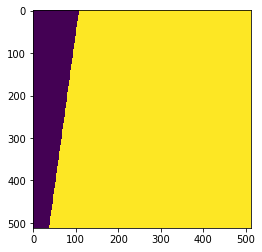

In [76]:
thresh, otsu_res = cv2.threshold(lab[:, :,0], cv2.THRESH_BINARY_INV, 255, 9)
print(thresh)
plt.imshow(otsu_res)

In [79]:
otsu_res.max()

255

In [64]:
lab[:, :,0].max()

218

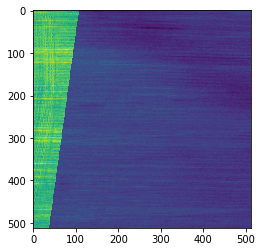

In [66]:
plt.imshow(lab[:, :,0])

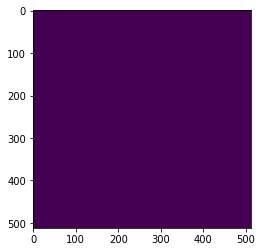

In [24]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1.0):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [26]:
df = pd.read_csv("/home/user/projects/agrivision/data/Agriculture-Vision/full_df_with_sum.csv")

In [28]:
train_df = df[df['ds_part'].isin(['train'])]

In [30]:
cloud_df = train_df[train_df['cloud_shadow'] != 0]

In [33]:
cloud_df.head(5)

,name,ds_part,double_plant,planter_skip,weed_cluster,waterway,cloud_shadow,standing_water
5,DY6QYQQN7_2128-3762-2640-4274.jpg,train,0.0,0.0,9366660.0,0.0,72614565.0,0.0
28,D74ZRGWTJ_1255-1174-1767-1686.jpg,train,0.0,0.0,0.0,0.0,124554240.0,0.0
42,A2GW8JMYA_7418-15818-7930-16330.jpg,train,0.0,0.0,0.0,0.0,81626265.0,0.0
55,T24XZ6PEI_1246-4263-1758-4775.jpg,train,0.0,0.0,0.0,0.0,15495075.0,0.0
57,A2GW8JMYA_1920-13636-2432-14148.jpg,train,0.0,0.0,113301855.0,0.0,54637830.0,0.0


In [266]:
label = 'cloud_shadow'
root_folder = "/home/user/projects/agrivision/data/Agriculture-Vision"

for num, row in tqdm_notebook(cloud_df.iterrows(), total=len(cloud_df)):
    mask_path = os.path.join(root_folder, row['ds_part'], 'labels', label, row['name'].replace(".jpg", ".png"))
    img_path = os.path.join(root_folder, row['ds_part'], 'images', 'rgb', row['name'])
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask > 0
    
    shadow_mask = get_shadow_mask(img_path, num_clusters=4)
    dice_result = dice_coef(y_pred=shadow_mask, y_true=mask)
    cloud_df.loc[num, 'dice'] = dice_result
    if num > 80:
        break

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [267]:
cloud_df[:10]

,name,ds_part,double_plant,planter_skip,weed_cluster,waterway,cloud_shadow,standing_water,dice
5,DY6QYQQN7_2128-3762-2640-4274.jpg,train,0.0,0.0,9366660.0,0.0,72614565.0,0.0,0.469942
28,D74ZRGWTJ_1255-1174-1767-1686.jpg,train,0.0,0.0,0.0,0.0,124554240.0,0.0,0.659582
42,A2GW8JMYA_7418-15818-7930-16330.jpg,train,0.0,0.0,0.0,0.0,81626265.0,0.0,0.666023
55,T24XZ6PEI_1246-4263-1758-4775.jpg,train,0.0,0.0,0.0,0.0,15495075.0,0.0,0.752671
57,A2GW8JMYA_1920-13636-2432-14148.jpg,train,0.0,0.0,113301855.0,0.0,54637830.0,0.0,0.873488
60,ZYI6ZLYNH_4084-9039-4596-9551.jpg,train,0.0,0.0,0.0,0.0,97247565.0,0.0,0.146032
110,T24XZ6PEI_5854-3239-6366-3751.jpg,train,0.0,0.0,0.0,0.0,184537125.0,0.0,0.496007
117,U888NW9IV_4723-4183-5235-4695.jpg,train,0.0,0.0,0.0,0.0,155468655.0,0.0,0.522717
121,DY6QYQQN7_3152-4274-3664-4786.jpg,train,0.0,0.0,13814370.0,0.0,154598850.0,0.0,0.356206
132,393VYUQ83_1341-4136-1853-4648.jpg,train,0.0,0.0,0.0,0.0,114225975.0,0.0,0.763233


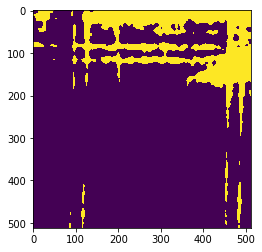

In [256]:
plt.imshow(shadow_mask)
# plt.imshow(mask)

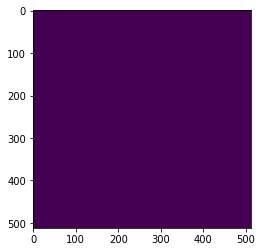

In [258]:
plt.imshow(mask)

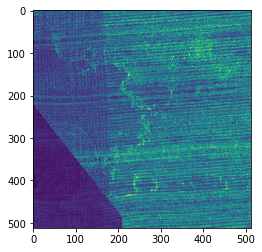

In [257]:
plt.imshow(lab[:, :, 0])

(array([3.0000e+01, 1.0100e+02, 4.8000e+02, 2.3260e+03, 8.1840e+03,
        5.7200e+03, 7.3520e+03, 4.2020e+03, 4.1950e+03, 3.1140e+03,
        3.5120e+03, 5.8760e+03, 5.0740e+03, 8.4490e+03, 7.1870e+03,
        9.9410e+03, 8.7120e+03, 9.9300e+03, 8.3200e+03, 1.1594e+04,
        7.9690e+03, 8.8540e+03, 1.0992e+04, 8.5320e+03, 1.1723e+04,
        8.0930e+03, 1.1231e+04, 7.9720e+03, 1.0350e+04, 7.4560e+03,
        9.4020e+03, 6.3780e+03, 5.8250e+03, 6.8030e+03, 4.5980e+03,
        4.8780e+03, 3.3570e+03, 3.4830e+03, 2.0750e+03, 2.3030e+03,
        1.3650e+03, 1.2690e+03, 7.8200e+02, 5.2800e+02, 5.0300e+02,
        3.0100e+02, 2.7500e+02, 1.0100e+02, 1.3600e+02, 7.5000e+01,
        8.0000e+01, 4.2000e+01, 3.3000e+01, 1.6000e+01, 1.4000e+01,
        1.4000e+01, 1.3000e+01, 6.0000e+00, 3.0000e+00, 5.0000e+00,
        5.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([ 29.      ,  32.453125,  35.90625 ,  39.359375,  42.8125  ,
         46.265625,  49.71875 ,  53.171875,  56.625   ,  6

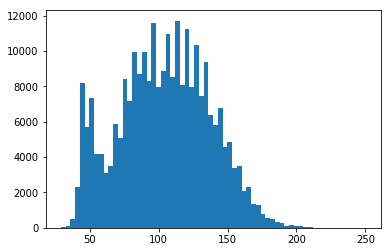

In [180]:
plt.hist(lab[:, :,0].flatten(), bins=64)

100.0


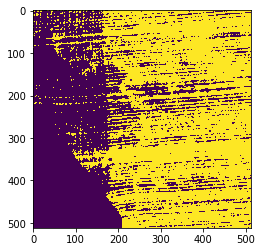

In [178]:
blur = cv2.GaussianBlur(lab[:, :,0],(3, 3), 0)
thresh, otsu_res = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(thresh)
# otsu_res = otsu_res < thresh
# otsu_res
plt.imshow(otsu_res)

In [189]:
from sklearn.cluster import KMeans

In [206]:
xs = np.arange(512)
ys = np.arange(512)
mesh = np.meshgrid(xs, ys)
xs = mesh[0].flatten()
ys = mesh[1].flatten()

coords = np.vstack([xs, ys, blur.flatten()]).T

In [265]:
def get_shadow_mask(img_path, num_clusters = 4):
    bgr_img = cv2.imread(img_path)
    lab= cv2.cvtColor(bgr_img, cv2.COLOR_BGR2LAB)
    blur = cv2.GaussianBlur(lab[:, :,0],(21, 21), 0)
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(np.expand_dims(blur.flatten(), axis=1))
    clustered_mask = kmeans.labels_.reshape((512, 512))

    masks = []
    min_light = 255
    mask = None
    for cl in range(num_clusters):
        cur_mask = clustered_mask == cl
        cur_light = np.median(blur[cur_mask])
        # print(cur_light)
        if cur_light < min_light:
            mask = cur_mask
            min_light = cur_light
            # print(cur_light)
#     if min_light > 155:
#         mask = np.zeros((512, 512))
    return mask

128.0
85.0
50.0


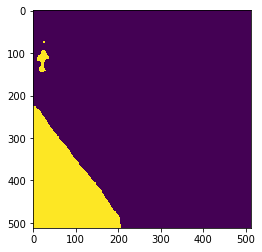

In [234]:
plt.imshow(mask)

In [207]:
coords.shape

(262144, 3)

In [200]:
mesh[0.shape]

SyntaxError: invalid syntax (<ipython-input-200-e087deb88dde>, line 1)

In [195]:
blur.flatten()

array([ 68,  78, 106, ..., 117, 119, 122], dtype=uint8)

In [209]:
kmeans.cluster_centers_

array([[124.34183514, 255.40036459,  84.39589723],
       [380.29983324, 255.59480525, 122.53075308]])

In [99]:
cv2.adaptiveThreshold(lab[:, :,0], 50, 60, 1, 29, 10)

error: OpenCV(3.4.1) /home/user/opencv-3.4.1/modules/imgproc/src/thresh.cpp:1557: error: (-206) Unknown/unsupported adaptive threshold method in function adaptiveThreshold


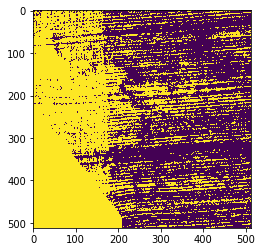

In [90]:
plt.imshow(otsu_res)

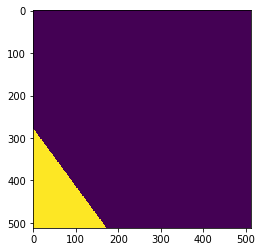

In [91]:
plt.imshow(mask)

In [87]:
cloud_df['dice']

5        0.551460
28       0.671305
42       0.643643
55       0.085329
57       0.414063
60       0.722333
110      0.875107
117      0.808508
121      0.771996
132      0.705668
144      0.585329
148      0.063419
159      0.253331
176      0.493784
179      0.904058
185      0.317708
194      0.684391
200      0.142267
205      0.564801
209      0.330397
212      0.000121
222      0.000004
248      0.000004
249      0.000004
250      0.000004
251      0.000004
252      0.000004
253      0.000004
254      0.691826
255      0.000004
           ...   
12481    0.363114
12488    0.803089
12496    0.746241
12521    0.655736
12543    0.155937
12573    0.564383
12589    0.208571
12601    0.623825
12608    0.242485
12615    0.776219
12631    0.861924
12659    0.753432
12673    0.388586
12674    0.707444
12701    0.842558
12714    0.889355
12726    0.510168
12728    0.882493
12735    0.557523
12738    0.388436
12750    0.439252
12751    0.901686
12790    0.892475
12802    0.629110
12815    0

In [22]:
lab[:, :, 0].max()

255